# Visualize results

## Library setup

Disable some console warnings

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Disable cell scrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Define some additional helpers

In [3]:
def get_results(filename, model_id_regex=''):
    import pandas as pd
    # Read CSV file
    csv_data = pd.read_csv(filename)
    return csv_data[csv_data.id.str.contains(model_id_regex, regex=True)]

In [4]:
def get_avg_results(filename, model_id_regex=''):
    import pandas as pd
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        # Get data from CSV file
        csv_data = get_results(filename, model_id_regex)
        
        # For each model, compute average for accuracy and number of tracks... 
        accuracy_avg = csv_data.groupby('id').accuracy.mean()
        nt_gev10_avg = csv_data.groupby('id').nt_gev10.mean()
        
        # For each model, compute standard deviation for accuracy and number of tracks... 
        accuracy_std = csv_data.groupby('id').accuracy.std()
        nt_gev10_std = csv_data.groupby('id').nt_gev10.std()        
        
        # For each model, append average and standard deviation as columns 
        csv_avg_std_data = pd.DataFrame(accuracy_avg)
        csv_avg_std_data = csv_avg_std_data.join(nt_gev10_avg, on='id')
        
        # Count occurrences of records for each model
        csv_data = pd.read_csv(filename, usecols=['id', 'accuracy'])
        csv_data_count = csv_data.groupby(['id']).count().rename(columns={'accuracy':'count'})
        
        # and append them as columns
        csv_avg_std_data = csv_avg_std_data.join(csv_data_count, on='id')
        
        return csv_avg_std_data

In [5]:
def print_results(filename, model_id_regex=''):
    import pandas as pd
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        csv_data = get_results(filename, model_id_regex)
        display(csv_data)

In [6]:
def print_avg_results(filename, model_id_regex=''):
    display(get_avg_results(filename, model_id_regex))

In [7]:
def plot_results(data, title, threshold_line, reverse=True):
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    with pd.option_context('display.float_format', '{:0.4f}'.format):
        # Backup figure size
        restore_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (10,10)

        #if id_ordering != None:
        #    df = df.reindex(id_ordering)
        #display(data)
        
        # Set ticks for y-axis
        yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        #ax = df.set_index('id').loc[id_ordering].plot.bar(rot=65, title='Avg metrics', ylim=[0.,1], yticks=yticks)
        
        if reverse:
            data = data.iloc[::-1]
        
        # Plot bar chart
        ax = data.plot.barh(rot=0, title=title, ylim=[0.,1], yticks=yticks)
        
        # Add bar labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', fontsize=8)
        
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

        # Put a legend below current axis
        ax.legend(
            loc='upper right',
            bbox_to_anchor=(0.5, -0.05),
            fancybox=True,
            shadow=True,
            ncol=5)
     
        # Drasw threshold line
        ax.axvline(threshold_line, color="lightblue", linestyle=":")
        ax.text(threshold_line, 0,
                str(threshold_line*100) + '%',
                va='center',
                ha='center',
                bbox=dict(facecolor="w",alpha=0.5, boxstyle='rarrow', edgecolor='lightblue'),
                #transform=ax.get_yaxis_transform(),
                rotation=90)
        
        # Restore figure size
        plt.rcParams["figure.figsize"] = restore_figsize

In [8]:
def print_dictionary(d, indent=0):
   for key, value in d.items():
      print('  ' * indent + str(key))
      if isinstance(value, dict):
         print_dictionary(value, indent+1)
      else:
         print('  ' * (indent+1) + str(value))

In [9]:
def get_model_ids(lrange=range(12),
                  srange=['noscaling'],
                  mrange=['keras_d64', 'qkeras_foldbatchnorm_d64w6a10', 'hls4ml_qkeras_foldbatchnorm_d64w6a10'],
                  reverse=True
                 ):
    import itertools as it
    id_ordering = ['ds8l{:02d}_{}_{}'.format(str(l), s, m) for [l, s, m] in it.product(
        lrange, # local bin
        srange, # dataset scaling
        mrange) # models
    ]
    if reverse:
        id_ordering.reverse()
    return id_ordering

In [10]:
def plot_box_model(filename, model_id, show_avg=True):
    # Import libraries
    import matplotlib.pyplot as plt
    import numpy as np

    data = [get_results(filename, model_id.format(l)).accuracy.values for l in range(12)]
    
    if show_avg:
        data_avg = np.average(np.asarray(data), axis=1)    
        data.append(np.array(data_avg))

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    # Creating axes instance
    #bp = ax.boxplot(data, patch_artist = False, notch ='False', vert = 0)
    bp = ax.boxplot(data, patch_artist=True)

    #colors = ['#0000FF', '#00FF00', '#FFFF00', '#FF00FF']
    #for patch, color in zip(bp['boxes'], colors):
    #    patch.set_facecolor(color)

    if show_avg:
        bp['boxes'][-1].set_facecolor('Orange')

    # changing color and linewidth of whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#8B008B', linewidth=1.5, linestyle=":")

    # changing color and linewidth of caps
    for cap in bp['caps']:
        cap.set(color='#8B008B', linewidth=2)

    # changing color and linewidth of medians
    for median in bp['medians']:
        median.set(color='red', linewidth=3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker='D', color='#e7298a', alpha=0.5)

    # x-axis labels
    x_axis_labels = ['l{}'.format(l) for l in range(12)]
    if show_avg:
        x_axis_labels.append('Avg.')
    ax.set_xticklabels(x_axis_labels)

    # Adding title
    plt.title(model_id)
    #plt.title(model_id.format('[0-11]'))

    # Removing top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    # show plot
    plt.show()

In [11]:
def plot_box_model_avg(filename, model_ids):
    # Import libraries
    import matplotlib.pyplot as plt
    import numpy as np

    def add_values(bp, ax):
        for element in ['medians']:
            for line in bp[element]:
                # Get the position of the element. y is the label you want
                (x_l, y),(x_r, _) = line.get_xydata()
                # Make sure datapoints exist 
                # (I've been working with intervals, should not be problem for this case)
                if not np.isnan(y): 
                    x_line_center = x_l + (x_r - x_l)/2
                    y_line_center = y  # Since it's a line and it's horisontal
                    # overlay the value:  on the line, from center to right
                    ax.text(x_line_center, y_line_center, # Position
                            '%.3f' % y, # Value (3f = 3 decimal float)
                            verticalalignment='bottom',
                            fontsize=8)
    
    
    data = []
    for model_id in model_ids:
        data_model = [get_results(filename, model_id.format(l)).accuracy.values for l in range(12)]
        data_avg = np.average(np.asarray(data_model), axis=1)    
        data.append(np.array(data_avg))

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    # Creating axes instance
    #bp = ax.boxplot(data, patch_artist = False, notch ='False', vert = 0)
    bp = ax.boxplot(data, patch_artist=True)

    for patch in bp['boxes']:
        patch.set_facecolor('Orange')

    # changing color and linewidth of whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#8B008B', linewidth=1.5, linestyle=":")

    # changing color and linewidth of caps
    for cap in bp['caps']:
        cap.set(color='#8B008B', linewidth=2)

    # changing color and linewidth of medians
    for median in bp['medians']:
        median.set(color='red', linewidth=3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker='D', color='#e7298a', alpha=0.5)

    # x-axis labels
    #ax.set_xticklabels([model_id.format('[0-11]') for model_id in model_ids], rotation=45)
    ax.set_xticklabels([model_id.strip('ds8l{}_noscaling').strip('foldbatchnorm') for model_id in model_ids], rotation=90)

    # Adding title
    plt.title('Model averages')

    # Removing top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    add_values(bp, ax)

    # show plot
    plt.show()

## Print all results

In [12]:
results_filename = 'csv/results.csv'

In [13]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20
0,20/01/2023 12:01:15,ds8l00_noscaling_keras_d128,0.5696,0.7454,0,0,0,0
1,20/01/2023 12:01:33,ds8l00_noscaling_qkeras_foldbatchnorm_d128w5a10,0.5733,0.7410,0,0,0,0
2,20/01/2023 12:01:44,ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d...,0.0000,0.7396,0,0,0,0
3,20/01/2023 12:02:21,ds8l01_noscaling_keras_d128,0.5665,0.7356,0,0,0,0
4,20/01/2023 12:02:45,ds8l01_noscaling_qkeras_foldbatchnorm_d128w5a10,0.5650,0.7364,0,0,0,0
...,...,...,...,...,...,...,...,...
2395,27/01/2023 07:57:53,ds8l09_noscaling_hls4ml_qkeras_foldbatchnorm_d...,0.0000,0.6886,0,0,0,0
2396,27/01/2023 07:58:13,ds8l10_noscaling_qkeras_foldbatchnorm_d58w4a8,0.7602,0.6604,0,0,0,0
2397,27/01/2023 07:58:23,ds8l10_noscaling_hls4ml_qkeras_foldbatchnorm_d...,0.0000,0.6214,0,0,0,0
2398,27/01/2023 07:58:38,ds8l11_noscaling_qkeras_foldbatchnorm_d58w4a8,0.8766,0.5773,0,0,0,0


In [14]:
print('Count:')

print('- Keras d128:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_keras_d128').shape[0])
print('- QKeras d128w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d128w5a10').shape[0])
print('- hls4ml d128w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10').shape[0])
print('- QKeras d128w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d128w4a8').shape[0])
print('- hls4ml d128w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8').shape[0])

print('- Keras d64:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_keras_d64').shape[0])
print('- QKeras d64w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d64w5a10').shape[0])
print('- hls4ml d64w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10').shape[0])
print('- QKeras d64w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d64w4a8').shape[0])
print('- hls4ml d64w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8').shape[0])

print('- Keras d60:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_keras_d60').shape[0])
print('- QKeras d60w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d60w5a10').shape[0])
print('- hls4ml d60w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10').shape[0])
print('- QKeras d60w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d60w4a8').shape[0])
print('- hls4ml d60w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8').shape[0])

print('- Keras d58:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_keras_d58').shape[0])
print('- QKeras d58w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d58w5a10').shape[0])
print('- hls4ml d58w5a10:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10').shape[0])
print('- QKeras d58w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_qkeras_foldbatchnorm_d58w4a8').shape[0])
print('- hls4ml d58w4a8:', get_results(results_filename, 'ds8l*[0-9]*[0-9]_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8').shape[0])

Count:
- Keras d128: 120
- QKeras d128w5a10: 120
- hls4ml d128w5a10: 120
- QKeras d128w4a8: 120
- hls4ml d128w4a8: 120
- Keras d64: 120
- QKeras d64w5a10: 120
- hls4ml d64w5a10: 120
- QKeras d64w4a8: 120
- hls4ml d64w4a8: 120
- Keras d60: 120
- QKeras d60w5a10: 120
- hls4ml d60w5a10: 120
- QKeras d60w4a8: 120
- hls4ml d60w4a8: 120
- Keras d58: 120
- QKeras d58w5a10: 120
- hls4ml d58w5a10: 120
- QKeras d58w4a8: 120
- hls4ml d58w4a8: 120


## Print result averages

Print all of the average results for each architecture and each model (y-local/bin)

In [15]:
print_avg_results(results_filename)

,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.731630,0.0,10
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.739287,0.0,10
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.728705,0.0,10
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.735175,0.0,10
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.729803,0.0,10
...,...,...,...
ds8l11_noscaling_qkeras_foldbatchnorm_d58w5a10,0.605114,0.0,10
ds8l11_noscaling_qkeras_foldbatchnorm_d60w4a8,0.576863,0.0,10
ds8l11_noscaling_qkeras_foldbatchnorm_d60w5a10,0.613390,0.0,10


Separately, print the average results for each model (y-local/bin) given an architecture

In [16]:
model_labels = [
          #'keras_d128',
          #'qkeras_foldbatchnorm_d128w5a10',
          'hls4ml_qkeras_foldbatchnorm_d128w5a10',
          #'qkeras_foldbatchnorm_d128w4a8',
          'hls4ml_qkeras_foldbatchnorm_d128w4a8',
          #
          #'keras_d64',
          #'qkeras_foldbatchnorm_d64w5a10',
          'hls4ml_qkeras_foldbatchnorm_d64w5a10',
          #'qkeras_foldbatchnorm_d64w4a8',
          'hls4ml_qkeras_foldbatchnorm_d64w4a8',
          #
          #'keras_d60',
          #'qkeras_foldbatchnorm_d60w5a10',
          'hls4ml_qkeras_foldbatchnorm_d60w5a10',
          #'qkeras_foldbatchnorm_d60w4a8',
          'hls4ml_qkeras_foldbatchnorm_d60w4a8',
          #
          #'keras_d58',
          #'qkeras_foldbatchnorm_d58w5a10',
          'hls4ml_qkeras_foldbatchnorm_d58w5a10',
          #'qkeras_foldbatchnorm_d58w4a8',
          'hls4ml_qkeras_foldbatchnorm_d58w4a8',
         ]

In [17]:
for m in model_labels:
    print('\nArchitecture:', m)
    reg_expression = 'ds8l*[0-9]*[0-9]_noscaling_'
    print_avg_results(results_filename, reg_expression + m)


Architecture: hls4ml_qkeras_foldbatchnorm_d128w5a10


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.739287,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.731032,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.737409,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.748182,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.734510,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.732036,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.757684,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.719188,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.716580,0.0,10



Architecture: hls4ml_qkeras_foldbatchnorm_d128w4a8


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.731630,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.722888,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.729017,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.736145,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.723902,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.722916,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.744583,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.706196,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.693858,0.0,10



Architecture: hls4ml_qkeras_foldbatchnorm_d64w5a10


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.736678,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.728369,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.733460,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.744058,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.733322,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.730409,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.755103,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.718365,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.715629,0.0,10



Architecture: hls4ml_qkeras_foldbatchnorm_d64w4a8


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.728399,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.720553,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.729139,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.735177,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.726923,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.719587,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.738139,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.703592,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.693303,0.0,10



Architecture: hls4ml_qkeras_foldbatchnorm_d60w5a10


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.733618,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.729007,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.734490,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.743383,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.733590,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.730490,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.755660,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.716100,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.714619,0.0,10



Architecture: hls4ml_qkeras_foldbatchnorm_d60w4a8


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.729803,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.721479,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.728838,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.732063,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.723426,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.719079,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.737746,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.702496,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.694074,0.0,10



Architecture: hls4ml_qkeras_foldbatchnorm_d58w5a10


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.735175,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.724780,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.736064,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.740450,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.732527,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.730396,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.754008,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.714593,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.715499,0.0,10



Architecture: hls4ml_qkeras_foldbatchnorm_d58w4a8


,accuracy,nt_gev10,count
id,,,
ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.728705,0.0,10
ds8l01_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.721176,0.0,10
ds8l02_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.725218,0.0,10
ds8l03_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.733944,0.0,10
ds8l04_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.725912,0.0,10
ds8l05_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.720518,0.0,10
ds8l06_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.735894,0.0,10
ds8l07_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.704047,0.0,10
ds8l08_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.692431,0.0,10


Collect the average results for each model. The average is computed across the various y-local bins.

In [18]:
import pandas as pd
avg_avg_results = {}
for m in model_labels:
    reg_expression = 'ds8l*[0-9]*[0-9]_noscaling_'
    avg_results = get_avg_results(results_filename, reg_expression + m)
    avg_avg_results['ds8_' + m] = avg_results.accuracy.mean()

avg_avg_results = pd.Series(avg_avg_results, name='accuracy')
avg_avg_results.index.name = 'id'
avg_avg_results = avg_avg_results.to_frame()

In [19]:
display(avg_avg_results)

,accuracy
id,
ds8_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.718933
ds8_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.700393
ds8_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.716051
ds8_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.698974
ds8_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.715922
ds8_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.697934
ds8_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.714923
ds8_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.699049


## Plots

### Plot bar diagram

Plot the average results for each model. The average is computed across the various y-local bins.

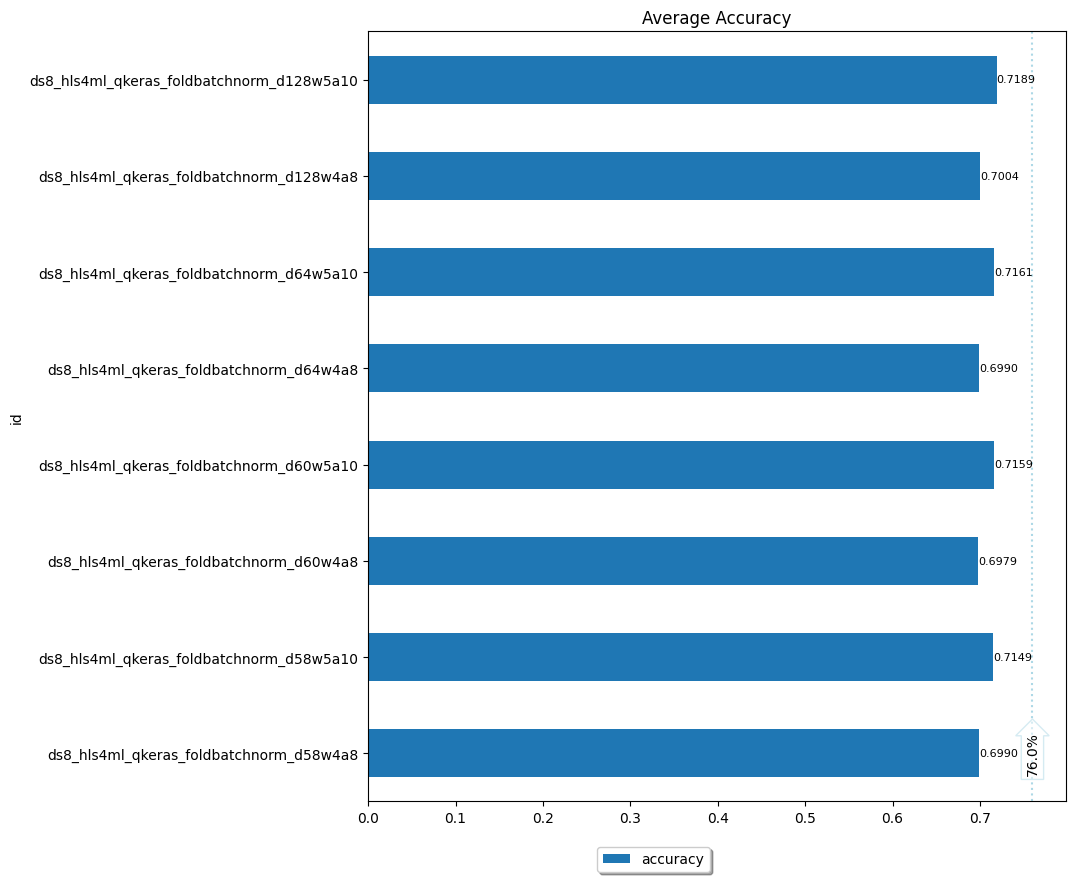

In [20]:
plot_results(avg_avg_results, title='Average Accuracy', threshold_line=0.76)

### Plot box-wisker diagrams

In [21]:
for m in model_labels:
    print('- ', m)

-  hls4ml_qkeras_foldbatchnorm_d128w5a10
-  hls4ml_qkeras_foldbatchnorm_d128w4a8
-  hls4ml_qkeras_foldbatchnorm_d64w5a10
-  hls4ml_qkeras_foldbatchnorm_d64w4a8
-  hls4ml_qkeras_foldbatchnorm_d60w5a10
-  hls4ml_qkeras_foldbatchnorm_d60w4a8
-  hls4ml_qkeras_foldbatchnorm_d58w5a10
-  hls4ml_qkeras_foldbatchnorm_d58w4a8


#### d128

##### Keras d128

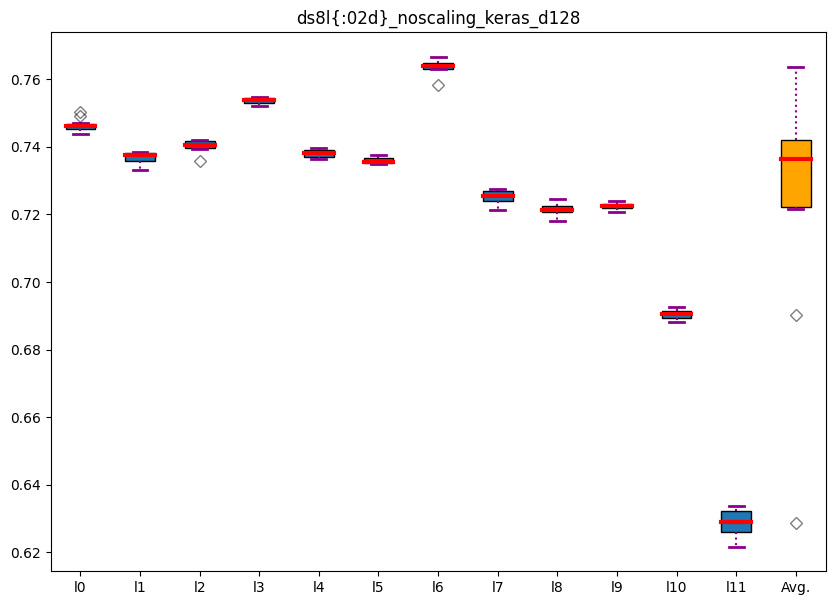

In [22]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_keras_d128')

##### QKeras (d128w5a10)

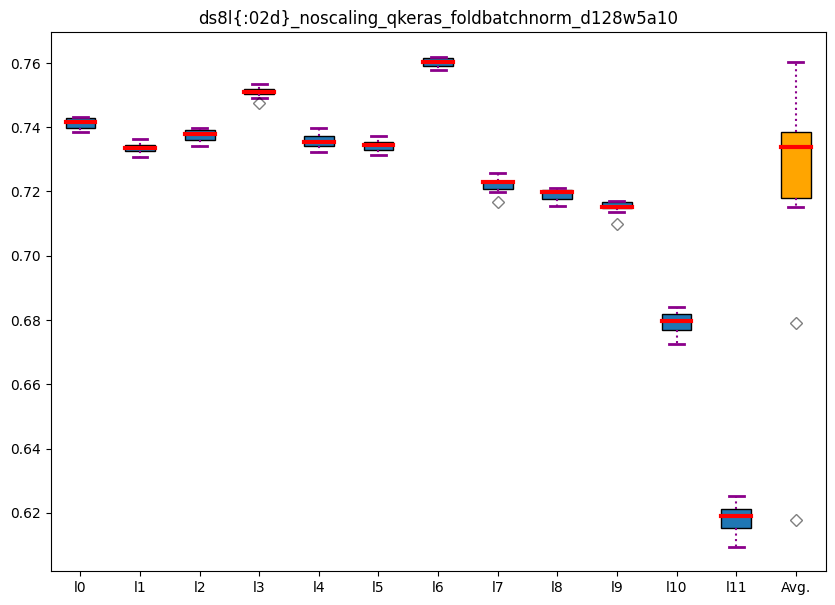

In [23]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d128w5a10')

##### hls4ml (d128w5a10)

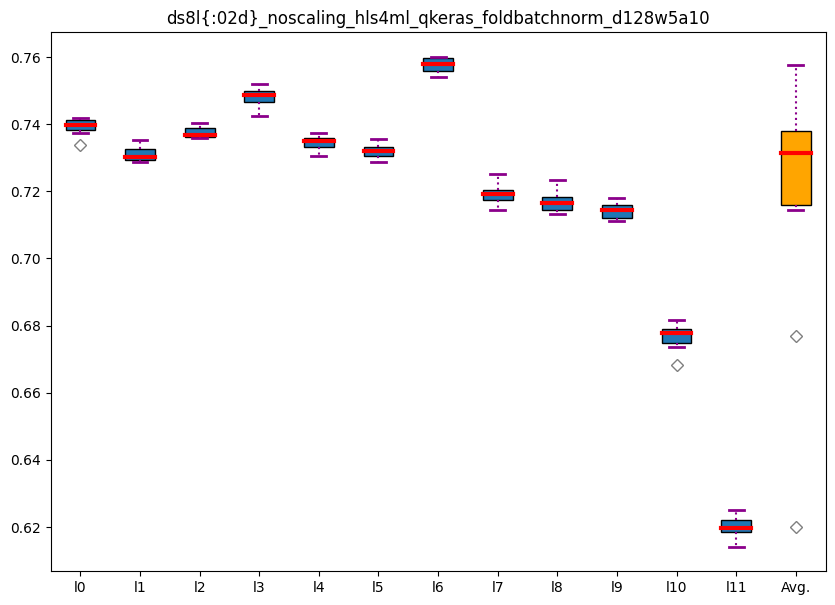

In [24]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10')

##### QKeras (d128w4a8)

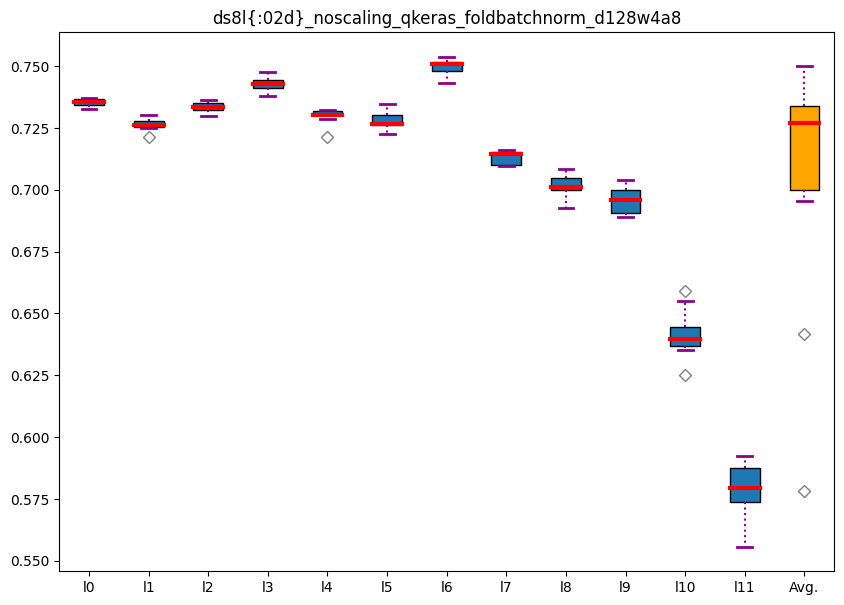

In [25]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d128w4a8')

##### hls4ml (d128w4a8)

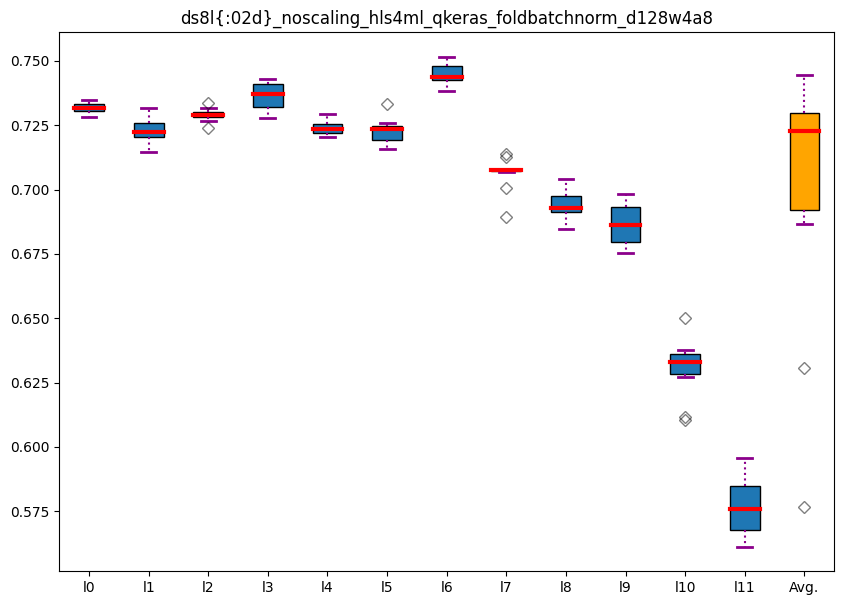

In [26]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8', show_avg=True)

#### d64

##### Keras d64

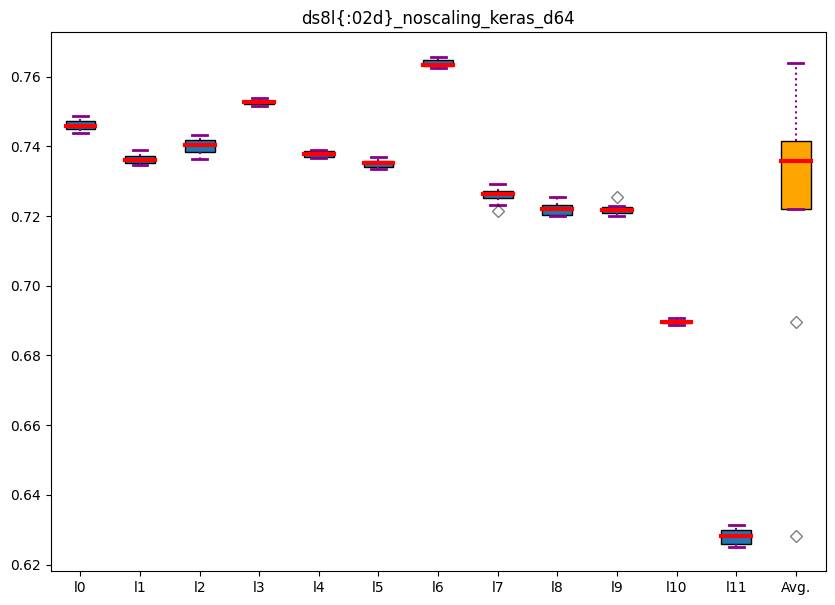

In [27]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_keras_d64')

##### QKeras (d64w5a10)

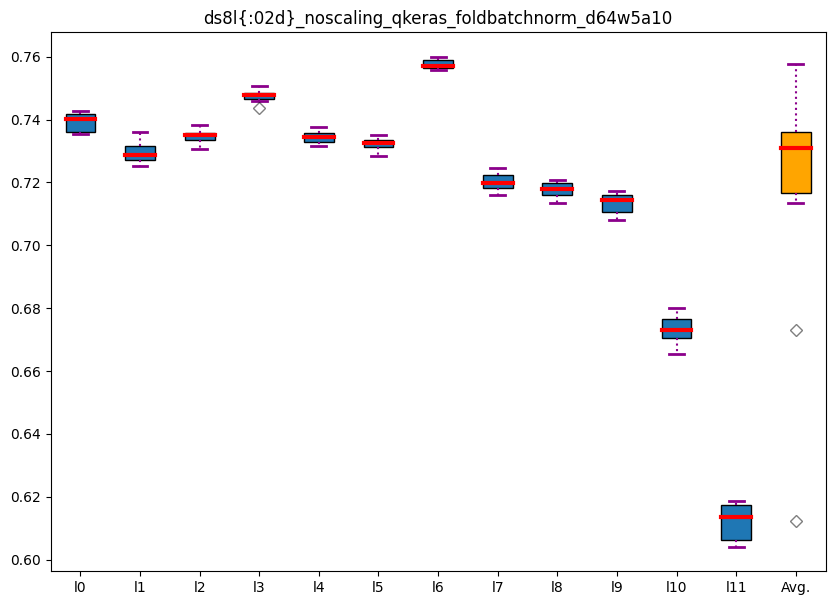

In [28]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d64w5a10')

##### hls4ml (d64w5a10)

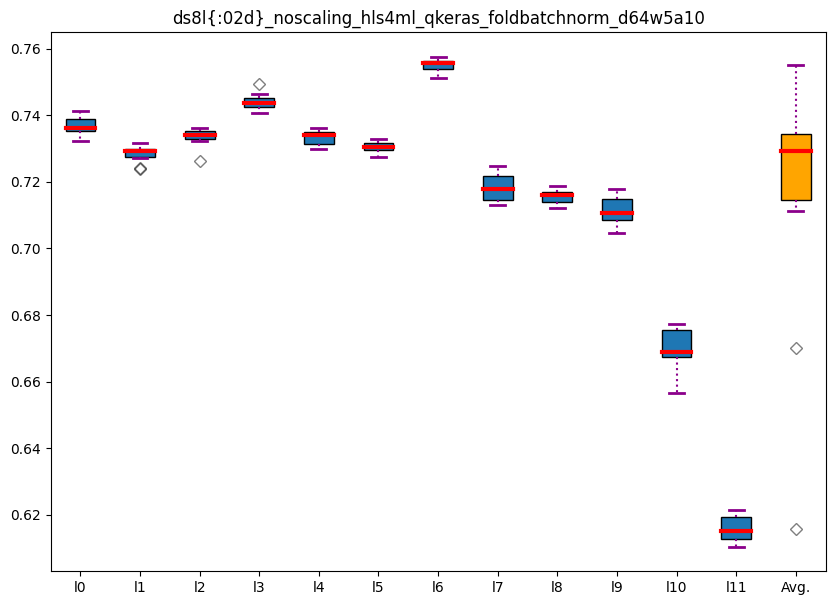

In [29]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10')

##### QKeras (d64w4a8)

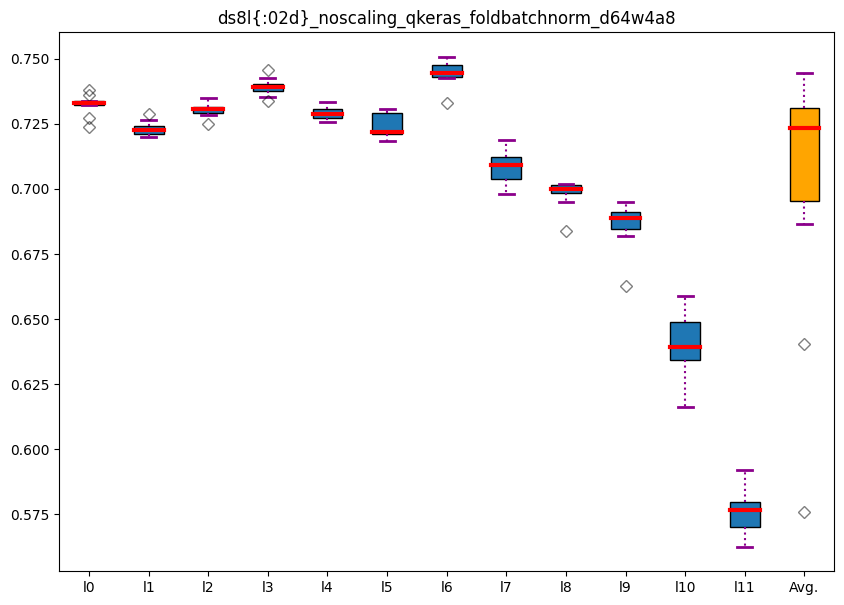

In [30]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d64w4a8')

##### hls4ml (d64w4a8)

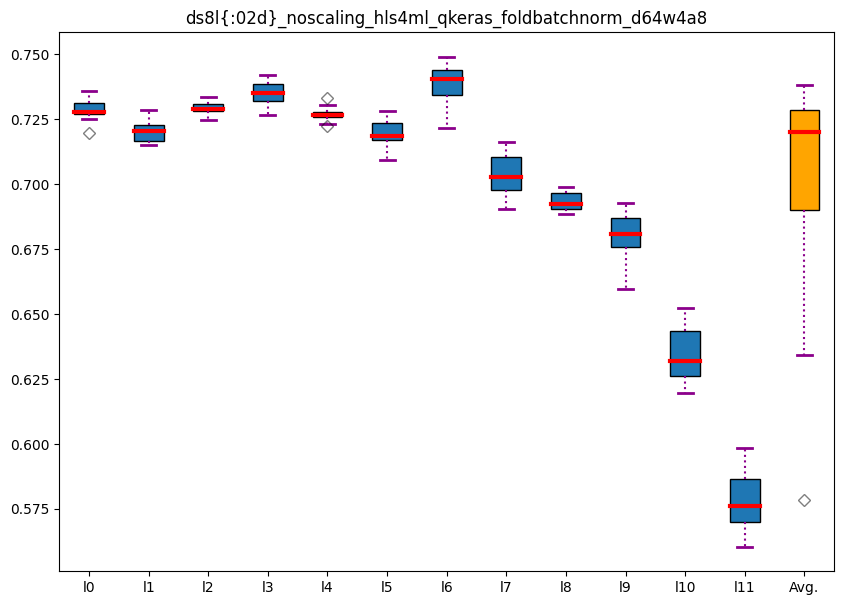

In [31]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8')

#### d60

##### Keras d60

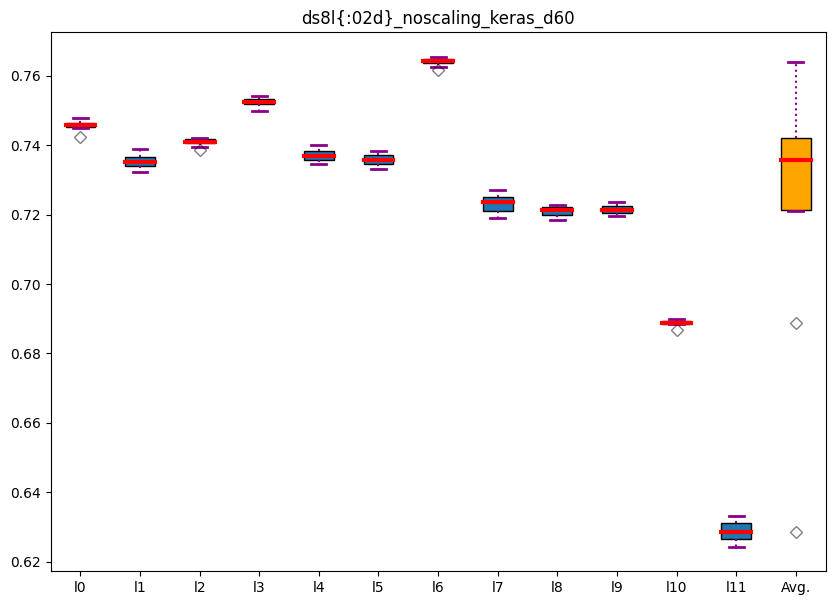

In [32]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_keras_d60')

##### QKeras (d60w5a10)

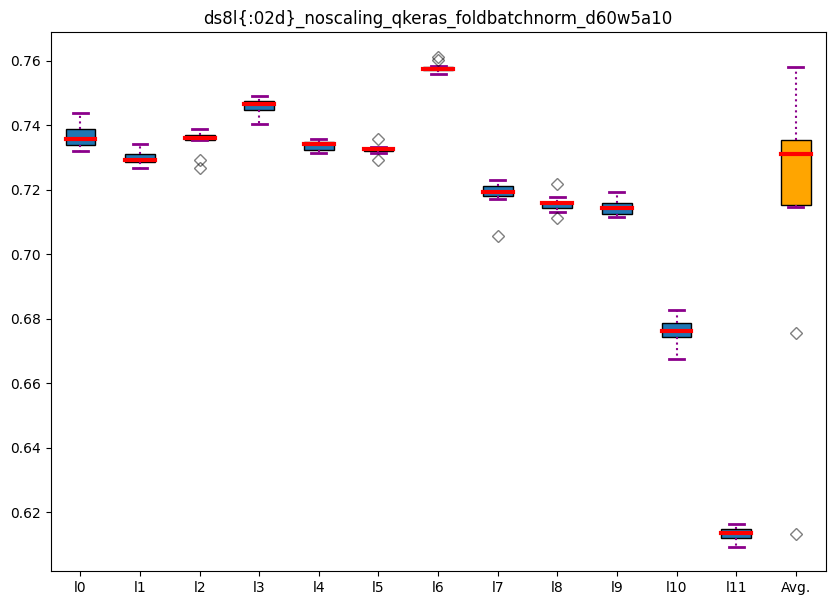

In [33]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d60w5a10')

##### hls4ml (d60w5a10)

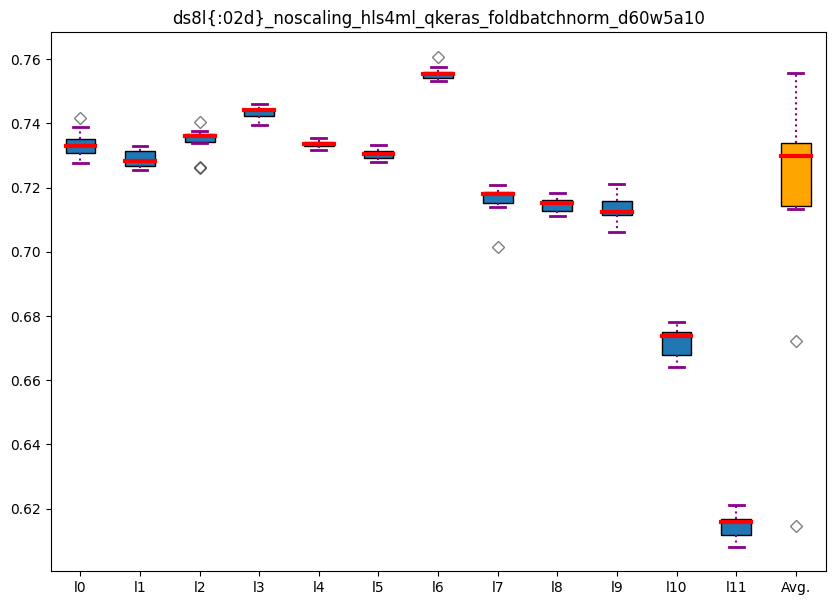

In [34]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10')

##### QKeras (d60w4a8)

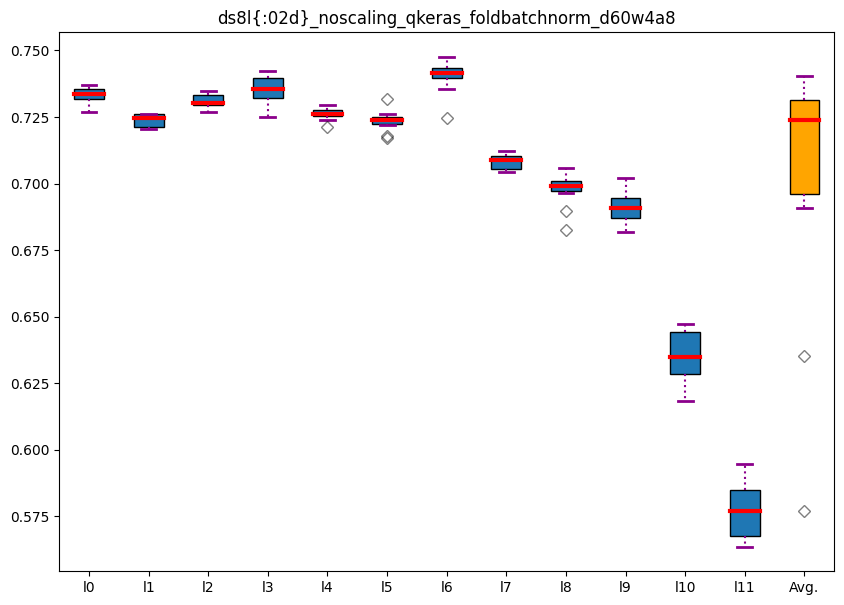

In [35]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d60w4a8')

##### hls4ml (d60w4a8)

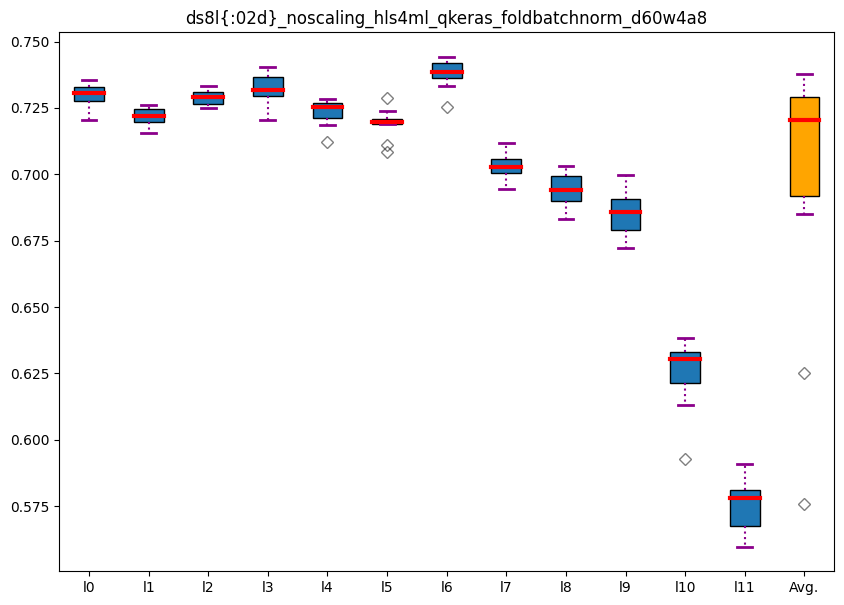

In [36]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8')

#### d58

##### Keras d58

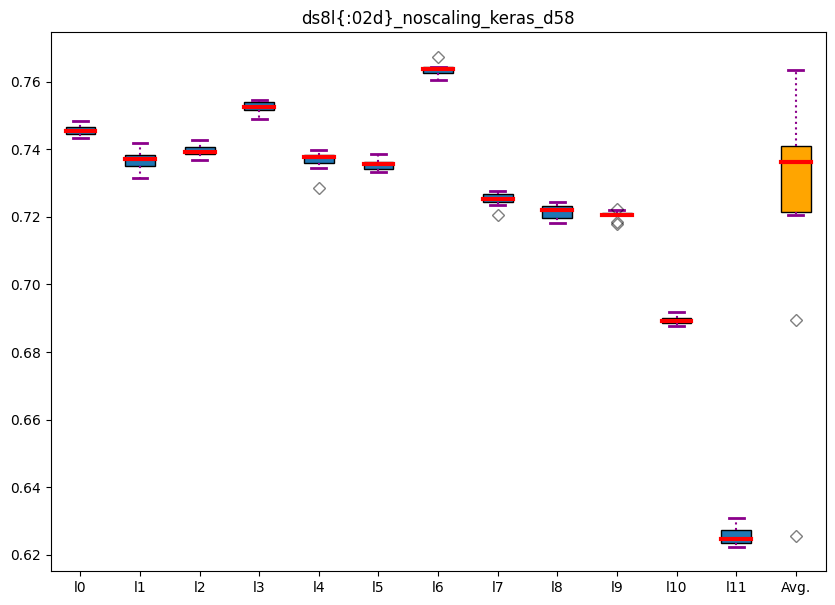

In [37]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_keras_d58')

##### QKeras (d58w5a10)

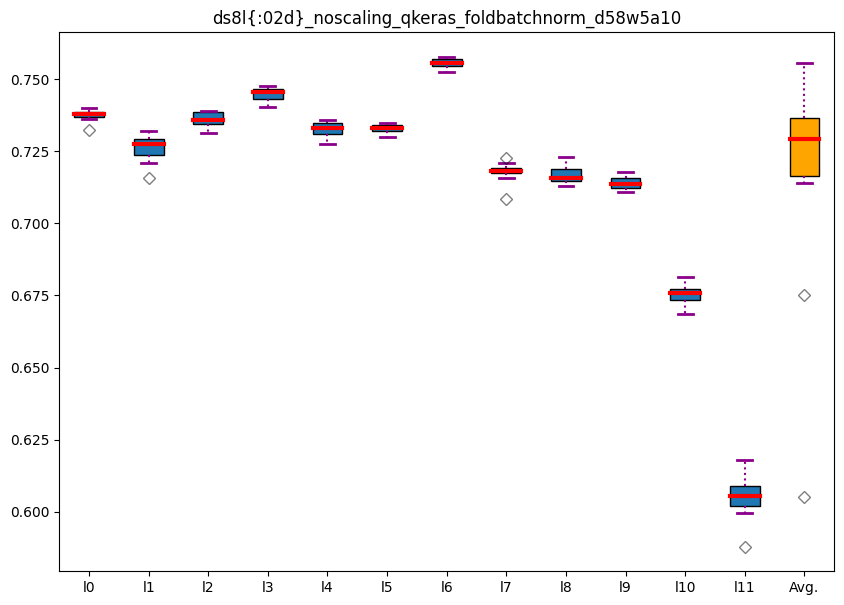

In [38]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d58w5a10')

##### hls4ml (d58w5a10)

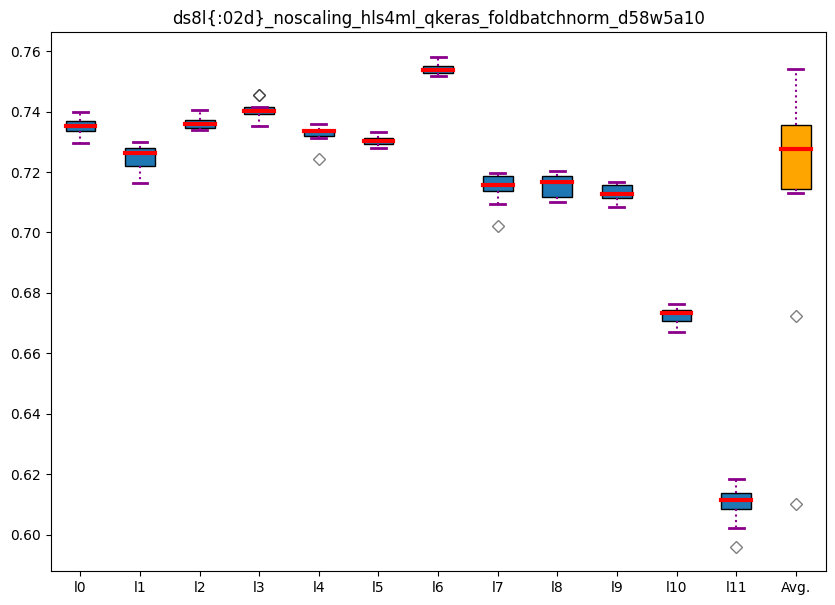

In [39]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10')

##### QKeras (d58w4a8)

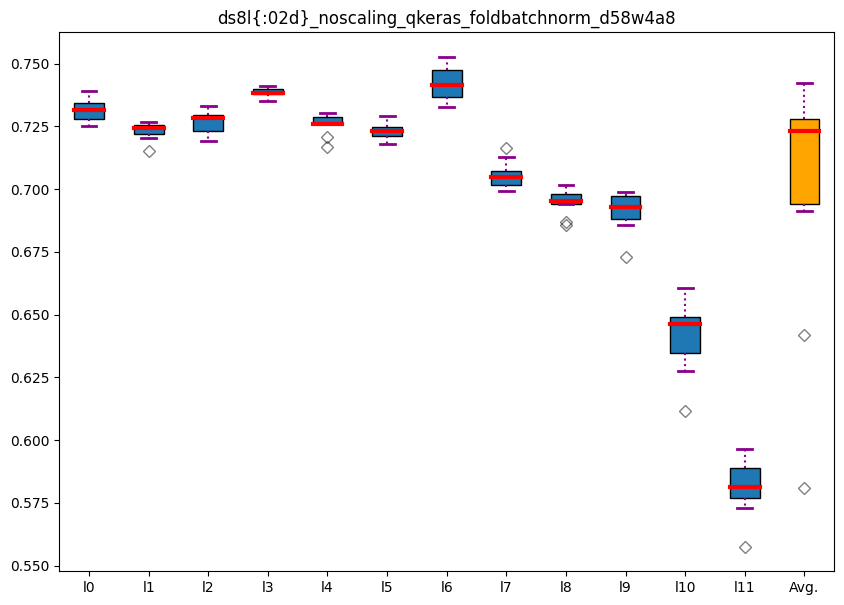

In [40]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_qkeras_foldbatchnorm_d58w4a8')

##### hls4ml (d58w4a8)

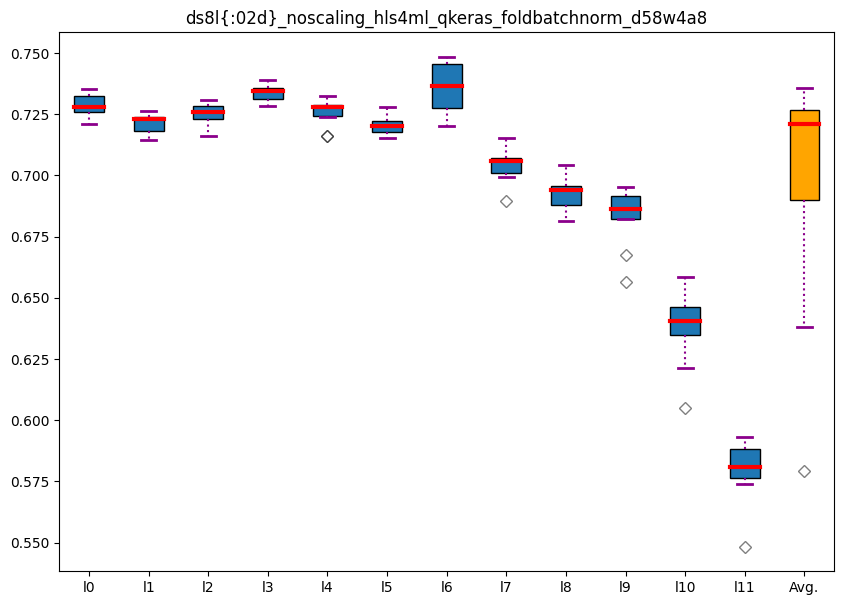

In [41]:
plot_box_model(results_filename, model_id='ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8')

#### Overall

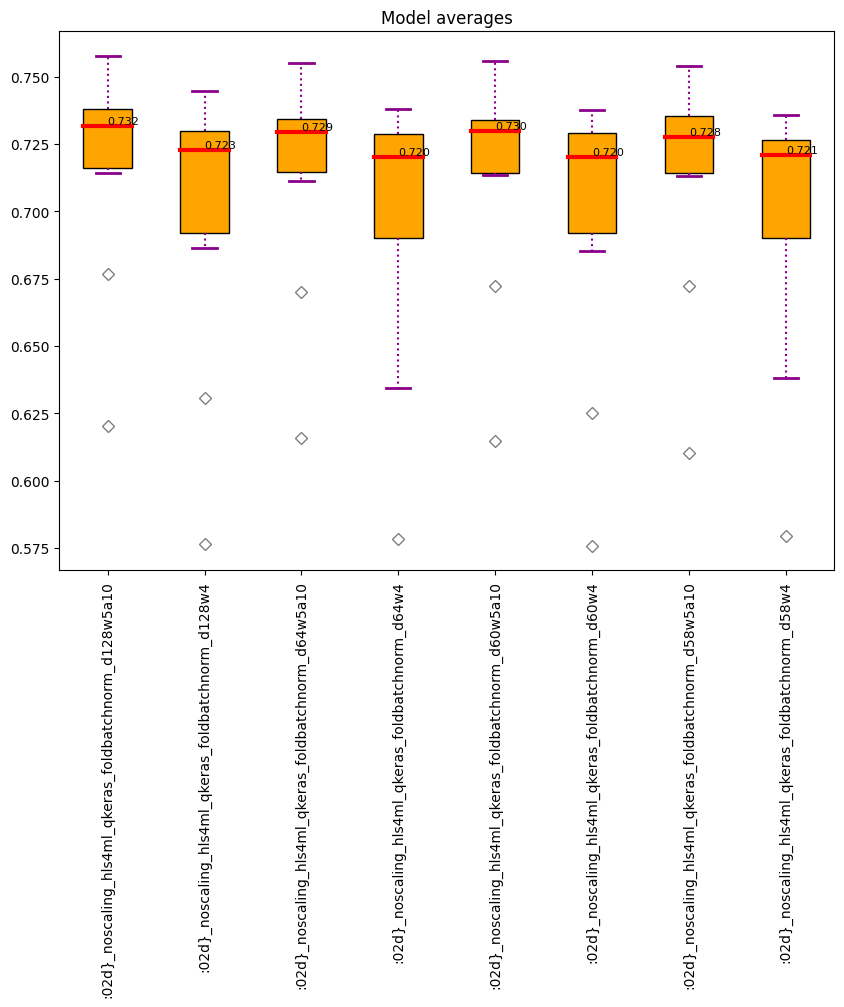

In [42]:
plot_box_model_avg(results_filename,
                   model_ids=[
                       #'ds8l{}_noscaling_keras_d128',                            #  Keras 16x128x3
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d128w5a10',        # QKeras 16x128x3, w5 a10
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10', # hls4ml 16x128x3, w5 a10
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d128w4a8',         # QKeras 16x128x3, w4 a8
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d128w4a8',  # hls4ml 16x128x3, w4 a8
                       #
                       #'ds8l{}_noscaling_keras_d64',                             # Keras   16x64x3
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d64w5a10',         # QKeras  16x64x3, w6 a10
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d64w5a10',  # hls4ml  16x64x3, w6 a10
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d64w4a8',          # QKeras  16x64x3, w4 a8
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d64w4a8',   # hls4ml  16x64x3, w4 a8
                       #
                       #'ds8l{}_noscaling_keras_d60',                             # Keras   16x60x3
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d60w5a10',         # QKeras  16x60x3, w6 a10
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d60w5a10',  # hls4ml  16x60x3, w6 a10
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d60w4a8',          # QKeras  16x60x3, w4 a8
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d60w4a8',   # hls4ml  16x60x3, w4 a8
                       #
                       #'ds8l{}_noscaling_keras_d58',                             # Keras   16x58x3
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d58w5a10',         # QKeras  16x58x3, w6 a10
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d58w5a10',  # hls4ml  16x58x3, w6 a10
                       #'ds8l{}_noscaling_qkeras_foldbatchnorm_d58w4a8',          # QKeras  16x58x3, w4 a8
                       'ds8l{:02d}_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8',   # hls4ml  16x58x3, w4 a8
                       #
                       ]
                  )

### Plot area vs. accuracy

In [43]:
area_results = {
    'ds8_hls4ml_qkeras_foldbatchnorm_d128w5a10': 10000,
    'ds8_hls4ml_qkeras_foldbatchnorm_d128w4a8':   9500,
    'ds8_hls4ml_qkeras_foldbatchnorm_d64w5a10':   8000,
    'ds8_hls4ml_qkeras_foldbatchnorm_d64w4a8':    7500,
    'ds8_hls4ml_qkeras_foldbatchnorm_d60w5a10':   6000,
    'ds8_hls4ml_qkeras_foldbatchnorm_d60w4a8':    5500,
    'ds8_hls4ml_qkeras_foldbatchnorm_d58w5a10':   4000,
    'ds8_hls4ml_qkeras_foldbatchnorm_d58w4a8':    3500
}

area_results = pd.Series(area_results, name='area')
area_results.index.name = 'id'
area_results = area_results.to_frame()

In [44]:
display(area_results)

,area
id,
ds8_hls4ml_qkeras_foldbatchnorm_d128w5a10,10000
ds8_hls4ml_qkeras_foldbatchnorm_d128w4a8,9500
ds8_hls4ml_qkeras_foldbatchnorm_d64w5a10,8000
ds8_hls4ml_qkeras_foldbatchnorm_d64w4a8,7500
ds8_hls4ml_qkeras_foldbatchnorm_d60w5a10,6000
ds8_hls4ml_qkeras_foldbatchnorm_d60w4a8,5500
ds8_hls4ml_qkeras_foldbatchnorm_d58w5a10,4000
ds8_hls4ml_qkeras_foldbatchnorm_d58w4a8,3500


In [45]:
accuracy_area_results = avg_avg_results
accuracy_area_results = accuracy_area_results.join(area_results, on='id')

In [46]:
display(accuracy_area_results)

,accuracy,area
id,,
ds8_hls4ml_qkeras_foldbatchnorm_d128w5a10,0.718933,10000
ds8_hls4ml_qkeras_foldbatchnorm_d128w4a8,0.700393,9500
ds8_hls4ml_qkeras_foldbatchnorm_d64w5a10,0.716051,8000
ds8_hls4ml_qkeras_foldbatchnorm_d64w4a8,0.698974,7500
ds8_hls4ml_qkeras_foldbatchnorm_d60w5a10,0.715922,6000
ds8_hls4ml_qkeras_foldbatchnorm_d60w4a8,0.697934,5500
ds8_hls4ml_qkeras_foldbatchnorm_d58w5a10,0.714923,4000
ds8_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.699049,3500


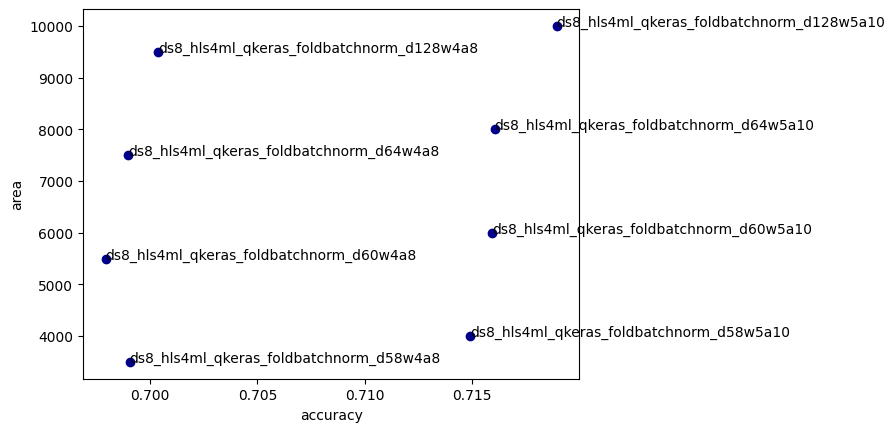

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots()
ax.scatter(
    x=accuracy_area_results['accuracy'],
    y=accuracy_area_results['area'],
    c='DarkBlue')

ax.set_xlabel('accuracy')
ax.set_ylabel('area')


for idx, row in accuracy_area_results.iterrows():
    ax.annotate(idx, (row['accuracy'], row['area']) )

plt.show()

In [48]:
model_id = 'ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10'
tmp = get_results(results_filename, model_id_regex=model_id).reset_index(drop=True)
best_model = tmp[tmp.accuracy.max() == tmp.accuracy]
#display(best_model)
index, accuracy = (best_model.index.values[0], best_model['accuracy'].values[0])
print(index, model_id, accuracy)

1 ds8l00_noscaling_hls4ml_qkeras_foldbatchnorm_d128w5a10 0.7417439035363989


## HW Results

In [49]:
def plot_box_data(data):
    # Import libraries
    import matplotlib.pyplot as plt
    import numpy as np

    def add_values(bp, ax):
        for element in ['medians']:
            for line in bp[element]:
                # Get the position of the element. y is the label you want
                (x_l, y),(x_r, _) = line.get_xydata()
                # Make sure datapoints exist 
                # (I've been working with intervals, should not be problem for this case)
                if not np.isnan(y): 
                    x_line_center = x_l + (x_r - x_l)/2
                    y_line_center = y  # Since it's a line and it's horisontal
                    # overlay the value:  on the line, from center to right
                    ax.text(x_line_center, y_line_center, # Position
                            '%.3f' % y, # Value (3f = 3 decimal float)
                            verticalalignment='bottom',
                            fontsize=8)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    # Creating axes instance
    #bp = ax.boxplot(data, patch_artist = False, notch ='False', vert = 0)
    bp = ax.boxplot(data, patch_artist=True)

    for patch in bp['boxes']:
        patch.set_facecolor('Orange')

    # changing color and linewidth of whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#8B008B', linewidth=1.5, linestyle=":")

    # changing color and linewidth of caps
    for cap in bp['caps']:
        cap.set(color='#8B008B', linewidth=2)

    # changing color and linewidth of medians
    for median in bp['medians']:
        median.set(color='red', linewidth=3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker='D', color='#e7298a', alpha=0.5)

    # x-axis labels
    #ax.set_xticklabels([model_id.format('[0-11]') for model_id in model_ids], rotation=45)
    #ax.set_xticklabels([model_id.strip('ds8l{}_noscaling').strip('foldbatchnorm') for model_id in model_ids], rotation=90)

    # Adding title
    plt.title('Model averages')

    # Removing top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    add_values(bp, ax)

    # show plot
    plt.show()

In [50]:
import pandas as pd
d64w5a10_hw_accuracy = pd.read_csv('csv/d64w5a10_hw_accuracy.csv')
d64w4a8_hw_accuracy = pd.read_csv('csv/d64w4a8_hw_accuracy.csv')

d60w5a10_hw_accuracy = pd.read_csv('csv/d60w5a10_hw_accuracy.csv')
d60w4a8_hw_accuracy = pd.read_csv('csv/d60w4a8_hw_accuracy.csv')

d58w5a10_hw_accuracy = pd.read_csv('csv/d58w5a10_hw_accuracy.csv')
d58w4a8_hw_accuracy = pd.read_csv('csv/d58w4a8_hw_accuracy.csv')


d64w5a10_mean = d64w5a10_hw_accuracy.mean().to_frame().T
d64w4a8_mean = d64w4a8_hw_accuracy.mean().to_frame().T

d60w5a10_mean = d60w5a10_hw_accuracy.mean().to_frame().T
d60w4a8_mean = d60w4a8_hw_accuracy.mean().to_frame().T

d58w5a10_mean = d58w5a10_hw_accuracy.mean().to_frame().T
d58w4a8_mean = d58w4a8_hw_accuracy.mean().to_frame().T

In [51]:
display(d64w5a10_mean.mean(axis=1))
display(d64w4a8_mean.mean(axis=1))

display(d60w5a10_mean.mean(axis=1))
display(d60w4a8_mean.mean(axis=1))

display(d58w5a10_mean.mean(axis=1))
display(d58w4a8_mean.mean(axis=1))

0    71.764948
dtype: float64

0    70.053948
dtype: float64

0    71.73658
dtype: float64

0    69.940547
dtype: float64

0    71.617106
dtype: float64

0    70.036389
dtype: float64

In [52]:
display(d64w5a10_mean.median(axis=1))
display(d64w4a8_mean.median(axis=1))

display(d60w5a10_mean.median(axis=1))
display(d60w4a8_mean.median(axis=1))

display(d58w5a10_mean.median(axis=1))
display(d58w4a8_mean.median(axis=1))

0    73.06786
dtype: float64

0    72.141395
dtype: float64

0    73.100655
dtype: float64

0    72.158215
dtype: float64

0    72.928655
dtype: float64

0    72.17066
dtype: float64

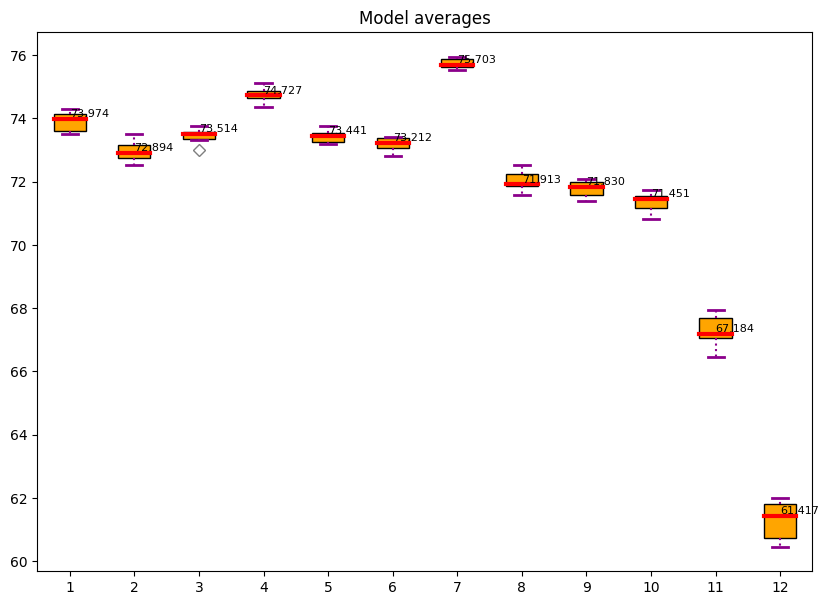

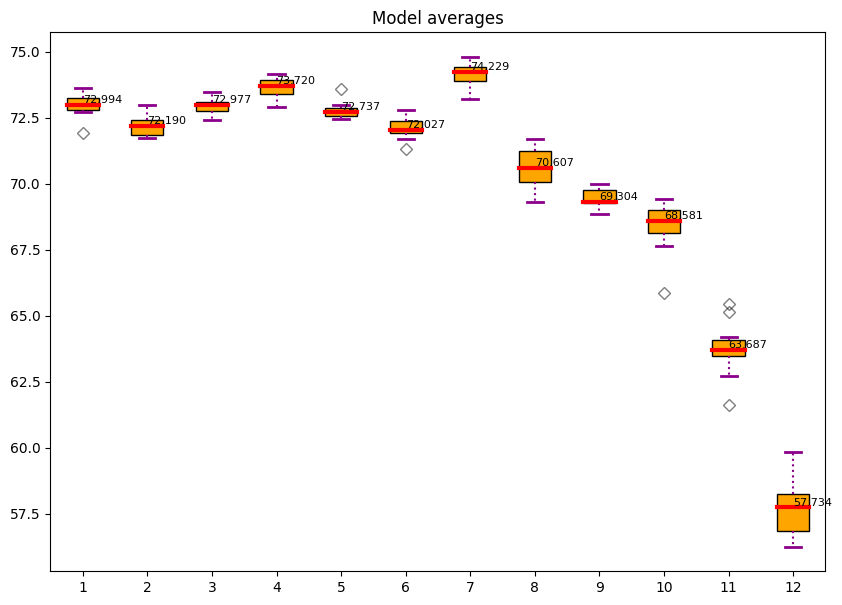

In [53]:
plot_box_data(d64w5a10_hw_accuracy)
plot_box_data(d64w4a8_hw_accuracy)

In [54]:
def from_45nm_to_28nm(area):
    scale_factor = (float(28*28)/(45*45))
    return [area[0] * float(scale_factor), area[1] * float(scale_factor)]

d64w5a10_hw_area_45nm = [210200.53, 174784.61]
d64w4a8_hw_area_45nm = [156058.63, 128473.21]

d60w5a10_hw_area_45nm = [197049.51, 163750.39]
d60w4a8_hw_area_45nm = [146291.51, 120338.66]

d58w5a10_hw_area_45nm = [190481.60, 158187.02]
d58w4a8_hw_area_45nm = [141416.30, 116816.03]

d64w5a10_hw_area_28nm = from_45nm_to_28nm(d64w5a10_hw_area_45nm)
d64w4a8_hw_area_28nm = from_45nm_to_28nm(d64w4a8_hw_area_45nm)

d60w5a10_hw_area_28nm = from_45nm_to_28nm(d60w5a10_hw_area_45nm)
d60w4a8_hw_area_28nm = from_45nm_to_28nm(d60w4a8_hw_area_45nm)

d58w5a10_hw_area_28nm = from_45nm_to_28nm(d58w5a10_hw_area_45nm)
d58w4a8_hw_area_28nm = from_45nm_to_28nm(d58w4a8_hw_area_45nm)

In [55]:
print('Area post syn for each architecture')
print('{} | @45nm {:8.2f} vs. @28nm {:8.2f}'.format('d64w5a10', d64w5a10_hw_area_45nm[1], d64w5a10_hw_area_28nm[1]))
print('{} | @45nm {:8.2f} vs. @28nm {:8.2f}'.format('d64w4a8', d64w4a8_hw_area_45nm[1], d64w4a8_hw_area_28nm[1]))

print('{} | @45nm {:8.2f} vs. @28nm {:8.2f}'.format('d60w5a10', d60w5a10_hw_area_45nm[1], d60w5a10_hw_area_28nm[1]))
print('{} | @45nm {:8.2f} vs. @28nm {:8.2f}'.format('d60w4a8', d60w4a8_hw_area_45nm[1], d60w4a8_hw_area_28nm[1]))

print('{} | @45nm {:8.2f} vs. @28nm {:8.2f}'.format('d58w5a10', d58w5a10_hw_area_45nm[1], d58w5a10_hw_area_28nm[1]))
print('{} | @45nm {:8.2f} vs. @28nm {:8.2f}'.format('d58w4a8', d58w4a8_hw_area_45nm[1], d58w4a8_hw_area_28nm[1]))


Area post syn for each architecture
d64w5a10 | @45nm 174784.61 vs. @28nm 67669.70
d64w4a8 | @45nm 128473.21 vs. @28nm 49739.75
d60w5a10 | @45nm 163750.39 vs. @28nm 63397.68
d60w4a8 | @45nm 120338.66 vs. @28nm 46590.38
d58w5a10 | @45nm 158187.02 vs. @28nm 61243.76
d58w4a8 | @45nm 116816.03 vs. @28nm 45226.55
